In [ ]:
# --- 1. Imports (เรียกไลบรารีที่จำเป็น) ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# --- 2. Load Data ---
file_path = 'UCI_Credit_Card.csv'
try:
    df = pd.read_csv(file_path)
    print(f"โหลดไฟล์ '{file_path}' สำเร็จ")
except FileNotFoundError:
    print(f"Error: ไม่พบไฟล์ '{file_path}'")
    exit() 

โหลดไฟล์ 'UCI_Credit_Card.csv' สำเร็จ


In [7]:
# --- 3. Initial Setup  ---
# Drop ID เป็นข้อมูลที่ไม่จำเป็น ในการ ฝึกโมเดล
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

# แยก X (Features) และ y (Target)
X = df.drop('default.payment.next.month', axis=1)
y = df['default.payment.next.month']

In [8]:
# ระบุกลุ่มคอลัมน์
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
numerical_features = [col for col in X.columns if col not in categorical_features]

In [9]:
# --- 4. Split Data ---
# แบ่งข้อมูลเป็น Train (80%) และ Test (20%)
# stratify=y เพื่อให้สัดส่วน class 0/1 ใน train/test เท่ากัน
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"แบ่งข้อมูล Train/Test เรียบร้อย: Train={X_train.shape[0]} แถว, Test={X_test.shape[0]} แถว")

แบ่งข้อมูล Train/Test เรียบร้อย: Train=24000 แถว, Test=6000 แถว


# --- 5. Create the Full Preprocessing & Model Pipeline ---

In [10]:
# 5.1 สร้างท่อสำหรับ Numerical features (Scaling)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 5.2 สร้างท่อสำหรับ Categorical features (One-Hot)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 5.3 รวมท่อ Preprocessing ทั้งสอง
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [11]:
# 5.4 สร้างโมเดล Logistic Regression
# *** นี่คือจุดสำคัญ: class_weight='balanced' ***
# เพื่อบอกโมเดลให้ "ลงโทษ" การทาย Class 1 (ผิดนัด) ผิด หนักกว่า Class 0
lr_model = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear', max_iter=1000)

# 5.5 รวม Preprocessor และ Model เข้าเป็น Pipeline สุดท้าย
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lr_model)
])

In [18]:
# --- 6. Train the Model ---
baseline_pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# --- 7. Evaluate the Model ---

In [14]:
# 7.1 ทำนายผล (Predict 0 หรือ 1)
y_pred = baseline_pipeline.predict(X_test)

# 7.2 ทำนายความน่าจะเป็น (Predict Probability)
y_proba = baseline_pipeline.predict_proba(X_test)

In [15]:
# 7.3 แสดง Classification Report
print("\n=== Classification Report (Baseline) ===")
# target_names บอกว่า 0 คือ 'Not Default', 1 คือ 'Default'
print(classification_report(y_test, y_pred, target_names=['Not Default (0)', 'Default (1)']))


=== Classification Report (Baseline) ===
                 precision    recall  f1-score   support

Not Default (0)       0.87      0.84      0.85      4673
    Default (1)       0.49      0.55      0.52      1327

       accuracy                           0.77      6000
      macro avg       0.68      0.69      0.69      6000
   weighted avg       0.78      0.77      0.78      6000




=== Confusion Matrix (Baseline) ===


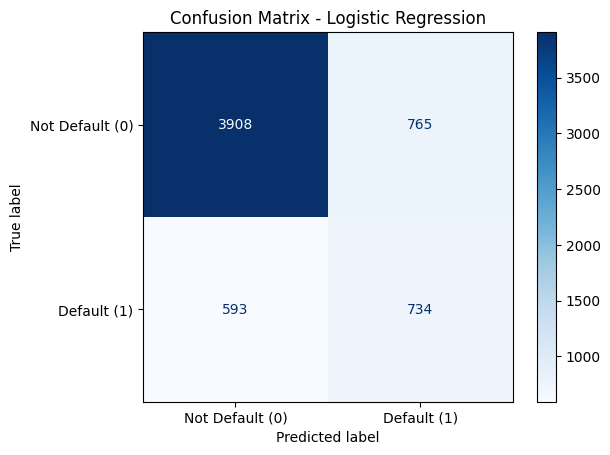

In [16]:
# 7.4 แสดง Confusion Matrix
print("\n=== Confusion Matrix (Baseline) ===")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Default (0)', 'Default (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [17]:
# 7.5 แสดงตัวอย่าง Probability (สำหรับ Dashboard)
print("\n--- ตัวอย่างการทำนายความน่าจะเป็น (สำหรับ Dashboard) ---")
print("    P(Not Default) | P(Default)")
print(y_proba[:5])


--- ตัวอย่างการทำนายความน่าจะเป็น (สำหรับ Dashboard) ---
    P(Not Default) | P(Default)
[[0.59756891 0.40243109]
 [0.53403786 0.46596214]
 [0.6404106  0.3595894 ]
 [0.72803097 0.27196903]
 [0.78730838 0.21269162]]
